# Virtual Ecosystem with Simple Boids

#### Simple Boid description
This boid can move 1 box each period, either horizontally, vertically or diagonally. When the boid moves to a location where there is food, the boid will eat the food, increasing the boid's energy. If the boid runs out of energy, the boid will stop moving. Simple Boid does not have a brain/path-finding algorithm, hence it can only move when movement coordinates are specified. 

When the boid passes over the env boundaries, there are 2 possible ways to adjust the boid location such that the boid remains within the env bounds. The default method is loop, where the boid teleports to the opposite side of the env. The other method ('wall') prevents the boid from moving off the env limits, and consumes energy as if the boid was moving

When a simple boid collides with another simple boid, the first boid will not move and consumes energy as if it had moved ('bump' collision). 

#### Env
Environment is represented by a numpy array. 0 represents an empty spot, 1 represents food, 5 represents a boid.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
import sys

from math import copysign # used to generate sign of integer (1 or -1)
from IPython.display import clear_output # allows jupyter to clear output using code

np.set_printoptions(linewidth=500)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

np.set_printoptions(threshold=sys.maxsize) # allows jupyter to show full numpy array

%matplotlib inline

## Essential Functions

In [2]:
# Function to create empty environment
def create_env(width, height):
    return np.zeros((width, height))

In [3]:
# Function to display environment frame by frame
# includes option to display frame counter to observe amount of time passed
# any text to be shown below frame must be passed into this function (this function is the last thing in the loop) 

def display_env_frame(env, delay, str_below=None, display_size = [7, 7]): # delay is the number of seconds previous frame stays visible
    # print frame counter
    try:
        global frame_num
        frame_num += 1
        print('Frame number: ', frame_num)
    except:
        pass
    
    # display frame
    fig, ax = plt.subplots(figsize=(display_size[0], display_size[1]))
    ax.set_axis_off()
    ax.matshow(env.T, origin='lower')
    plt.pause(0.001)
    
    # print string below if str_below is string
    if type(str_below) == str:
        print(str_below)
    
    # wait
    time.sleep(delay)
    
    return str_below


In [4]:
# Function to clear output (doesn't seem to work with Jupyter Notebook, might work with console)
from os import system, name 
  
# import sleep to show output for some time period 
from time import sleep 
  
# define our clear function 
def clear(): 
  
    # for windows 
    if name == 'nt': 
        _ = system('cls') 
  
    # for mac and linux(here, os.name is 'posix') 
    else: 
        _ = system('clear')

## Setting up Environment with Food

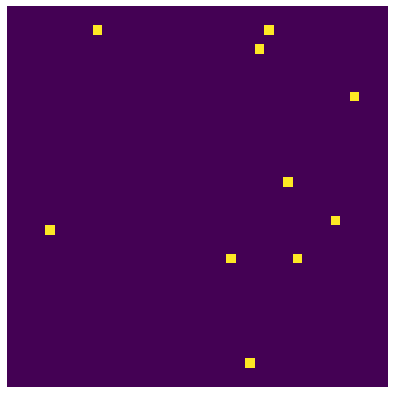

In [6]:
# Visualize adding food randomly to environment
# food represented by 1 in env array

# variables
env_width = 40
env_height = 40
frame_delay = 0.3 # time between frames
num_food = 10
food_value = 1

# initilize environment
env = create_env(env_width, env_height)
# display initial state of env
display_env_frame(env, frame_delay)
clear_output(wait=True)

# generate food in iterations and displays the food being added to env
while np.sum(env) / food_value < num_food:
    food_x_coor = random.randint(0, env_width - 1)
    food_y_coor = random.randint(0, env_height - 1)
    if env[food_x_coor][food_y_coor] == 0:
        env[food_x_coor][food_y_coor] = food_value
    else:
        continue
    display_env_frame(env, frame_delay)
    clear_output(wait=True)

In [7]:
# Function to add food to environment without displaying environment
def add_food(env, num_food, food_value=1):
    food_counter = 0
    while food_counter < num_food:
        food_x_coor = random.randint(0, env_width - 1)
        food_y_coor = random.randint(0, env_height - 1)
        if env[food_x_coor][food_y_coor] == 0:
            env[food_x_coor][food_y_coor] = food_value
            food_counter += 1
        else:
            continue
    return env

## Creating A Boid

In [36]:
# Animal: Boid
class SimpleBoid:
    
    def __init__(self, name_, collision_='bump', edge_='loop'):
        self.name_ = name_ # set a name == var name
        self.location_ = [random.randint(0, env.shape[0] - 1), random.randint(0, env.shape[1] - 1)]
        self.energy_ = 100
        self.collision_= collision_
        self.edge_ = edge_
        self.death_msg_ = str(self.name_) + ' has died!'
        self.food_eaten_ = 0
        # mark boid starting location in env
        env[self.location_[0], self.location_[1]] = 5
        
    def set_location(self, x_coor, y_coor):
        env[self.location_[0], self.location_[1]] = 0
        self.location_ = [x_coor, y_coor]
        env[self.location_[0], self.location_[1]] = 5
    
    
    # checks if boid location exceeds env limits
    def check_edge(self):
        if self.edge_ == 'loop':
            self.location_ = env_edge_loop(self.location_)
        elif self.edge_ == 'wall':
            self.location_ = env_edge_wall(self.location_)
    
    
    # move 1 step in any direction (including diagonally), check edge, check food, check collision
    def simple_move(self, x_move, y_move):
        # move boid
        self.location_[0] += int(x_move)
        self.location_[1] += int(y_move)
        
        # check if passed edge
        self.check_edge()

        # bump collision
        if self.collision_ == 'bump':
            # check if there is a boid in target location
            if env[self.location_[0], self.location_[1]] == 5:
                # reverse movement
                self.location_[0] -= int(x_move)
                self.location_[1] -= int(y_move)
                # check edge
                self.check_edge()
                
        # food check
        if env[self.location_[0], self.location_[1]] == 1:
            self.eat()
            
            
    # move 1 step in any direction (including diagonally), edit env, update energy
    def move(self, x_move, y_move):
        # if boid is dead, dont move
        if self.name_ == 'dead':
            return
        
        # delete initial position of boid
        env[self.location_[0], self.location_[1]] = 0
        
        # energy cost when moving/not moving
        if x_move == 0 and y_move == 0:
            self.energy_change(-1)
        else:
            self.energy_change(-2)
        
        # move boid 1 step (and check if food is on target coor)
        self.simple_move(x_move, y_move)
        
        # mark new position if not dead
        if self.name_ != 'dead':
            env[self.location_[0], self.location_[1]] += 5
        
    
    def eat(self):
        env[self.location_[0], self.location_[1]] -= 1
        self.energy_ += 20
        self.food_eaten_ += 1
        
        
    def die(self):
        # delete boid from env
        env[self.location_[0], self.location_[1]] = 0
        # print death alert
        print(self.death_msg_)
        self.name_ = 'dead'
        self.energy_ = 0
    
    
    def energy_change(self, energy_amount):
        self.energy_ += energy_amount
        # check if energy has run out, if no energy then boid dies 
        if self.energy_ <= 0:
            self.die()
    
    def display_info(self):
        name_str = str(self.name_) + ': '
        energy_str = 'Energy-' + str(self.energy_) + ' '
        food_str = 'Food-' + str(self.food_eaten_)
        return name_str + energy_str + food_str
    
    '''
    # check status after every period before display
    def check_status(self):
        # if 2 boid stand on the same pixel, both boids will die
        if env[self.location_[0], self.location_[1]] > 5:
            self.die()
    '''

In [32]:
# Important functions used by boid 

def env_edge_loop(ini_loc):  # ini_loc is initial location
    # env limits
    max_env_coor = [env.shape[0], env.shape[1]]
        
    # check if location of boid and loop if boid exceeds env limits
    for index in [0, 1]:
        if ini_loc[index] == max_env_coor[index]:
            ini_loc[index] = 0
        elif ini_loc[index] == -1:
            ini_loc[index] = max_env_coor[index] - 1

    # returns new coordinates adjusted for env edges
    return ini_loc
    

def env_edge_wall(ini_loc):
    # env limits
    max_env_coor = [env.shape[0], env.shape[1]]
    
    # location check
    for index in [0, 1]:
        if ini_loc[index] == max_env_coor[index]:
            ini_loc[index] -= 1
        elif ini_loc[index] == -1:
            ini_loc[index] += 1
    
    
    # return new coordinates adjusted for edges
    return ini_loc

## Checks

Before [30, 30]
Before [30, 30]
Movement coor: [1, 1]
Frame number:  55


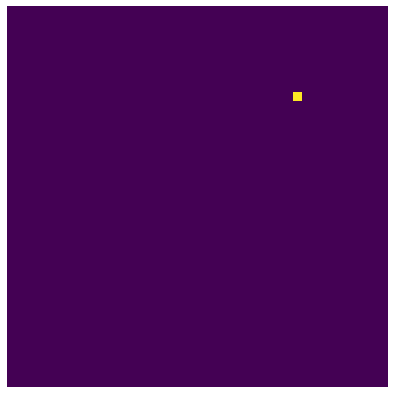

In [29]:
# Movement checks

# reset env
frame_num = 0
env_width = env_height = 40
env = create_env(env_width, env_height)

x_coor = y_coor = range(-1, 2)
movement_coor = []
for x in x_coor:
    for y in y_coor:
        movement_coor.append([x, y])

# initialize boid
boid2 = SimpleBoid('boid2')
# set boid attr
boid2.energy_ = 1000
boid2.set_location(30, 30)
display_env_frame(env, 3)
clear_output(wait=True)

for coor in movement_coor:
    for _ in range(6):
        boid2.move(coor[0], coor[1])
        display_above = 'Movement coor: ' + str(coor)
        print(display_above)
        display_env_frame(env, 0.3)
        clear_output(wait=True)
        if boid2.name_ == 'dead':
            break
    if boid2.name_ == 'dead':
        break

In [ ]:
# Collision check
frame_num = 0
env = create_env(20, 20)
display_size = [5, 5]

boid1 = SimpleBoid('boid1')
boid2 = SimpleBoid('boid2')
boid3 = SimpleBoid('boid3')

boid1.set_location(10, 10)
boid2.set_location(10,14)
boid3.set_location(5, 5)

display_env_frame(env, 3, display_size=display_size)
clear_output(wait=True)

for _ in range(8):
    boid1.move(0, 0)
    boid2.move(0, -1)
    display_env_frame(env, 1, display_size=display_size)
    clear_output(wait=True)

Before [10, 4]
Before [10, 4]
boid2: Energy-84 Food-0
Frame number:  9


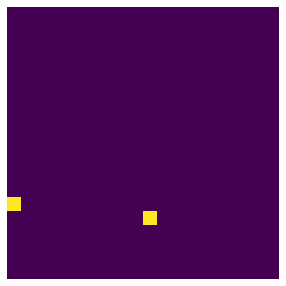

In [33]:
# Edge check
frame_num = 0
env = create_env(20, 20)
display_size = [5, 5]

boid1 = SimpleBoid('boid1')
boid2 = SimpleBoid('boid2', edge_='wall')
boid1.set_location(10, 16)
boid2.set_location(4, 5)

display_env_frame(env, 3, display_size=display_size)
clear_output(wait=True)

for _ in range(8):
    boid1.move(0, 1)
    boid2.move(-1, 0)
    print(boid2.display_info())
    display_env_frame(env, 1, display_size=display_size)
    clear_output(wait=True)

## Make a Boid Move Randomly in Environment with Food

In [10]:
# Define function for boid to move randomly in a similar pattern as 'move_random()'
# this functions makes the boid move 1 step
# previous path takes priority, if no path is available (num_steps = 0), then new path is generated

# path = [x_direction, y_direction, path_num_steps]

def move_random_path(boid, path, display=True, max_num_steps=5, delay=1):
    if path == None:
        return None
    
    if path[2] == 0:
        x_direction = random.randint(-1, 1)
        y_direction = random.randint(-1, 1)
        num_steps = random.randint(1 , max_num_steps)
        path = [x_direction, y_direction, num_steps]
        
    boid.move(path[0], path[1])
    if boid.name_ == 'dead':
        return None
    
    path[2] -= 1
    if display:
        display_above = 'Direction: ' + str([path[0], path[1]]) + '\nSteps Remaining: ' + str(path[2]) + '\nBoid Energy: ' + str(boid.energy_)
        print(display_above)
    
    return path

boid1 has died!
Frame number:  54


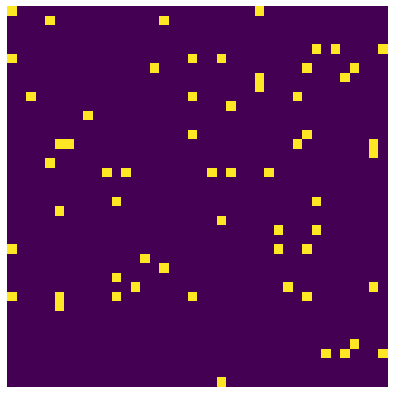

In [11]:
# variables
env_width = env_height = 40
frame_num = 0 # frame counter
frame_delay = 0.7
max_steps = 3 # max steps in any 1 direction
max_periods = 100 # max number of periods
num_food = 20
path = [0, 0, 0] # starting path (do not change)

# initialize env
env = create_env(env_width, env_height)

# add food
env = add_food(env, num_food)

# initialize boid
boid1 = SimpleBoid('boid1')

# display boid and food
print('Boid Energy: ' + str(boid1.energy_))
display_env_frame(env, 2)
clear_output(wait=True)

while frame_num < max_periods:
    
    if frame_num % 20 == 0:
        env = add_food(env, num_food)
    path = move_random_path(boid1, path)
    display_env_frame(env, frame_delay)
    if boid1.name_ == 'dead':
        break
    clear_output(wait=True)

## Multiple Boids Moving Randomly in Environment with Food

dead: Energy-0 Food-0
dead: Energy--1 Food-3
boid3: Energy-51 Food-7
dead: Energy-0 Food-2
dead: Energy--1 Food-0
Frame number:  100


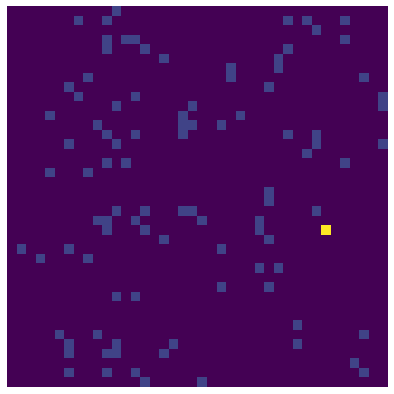

In [44]:
# variables
env_width = env_height = 40
frame_num = 0 # frame counter
frame_delay = 0.8
max_steps = 3 # max steps in any 1 direction
max_periods = 100 # max number of periods
num_food = 20
num_boids = 5
paths = [[0, 0, 0] for _ in range(num_boids)] # starting path (do not change)
order_list = [x for x in range(num_boids)]  # index list to synchronize shuffling
random.shuffle(order_list)

# initialize env
env = create_env(env_width, env_height)

# add food
env = add_food(env, num_food)

# initialize boids
boids = [SimpleBoid('boid' + str(x), edge_='wall') for x in range(1, num_boids+1)]

# display boids and food
for boid in boids:
    print(boid.display_info())

display_env_frame(env, 3)
clear_output(wait=True)

while frame_num < max_periods:
    # add food every 10 periods
    if frame_num % 10 == 0:
        env = add_food(env, num_food/2)
    
    # shuffle order or boid movement
    random.shuffle(order_list)
    new_paths = [move_random_path(boids[x], paths[x], display=False) for x in order_list]
    for x in range(num_boids):
        paths[order_list[x]] = new_paths[x]
    
    # print boids and env
    for index in range(num_boids):
        print(boids[index].display_info())
    display_env_frame(env, frame_delay)
    
    # exit loop if all boids die
    if all([path == None for path in paths]):
        break
    clear_output(wait=True)

## Creating a Boid with a Brain

In [36]:
# Animal: Boid with neural network to make decisions on movement
class BrainyBoid:
    
    def __init__(self, name_, collision_='bump', edge_='loop'):
        # set a name == var name
        self.name_ = name_ 
        
        # generate random location and mark on env
        self.location_ = [random.randint(0, env.shape[0] - 1), random.randint(0, env.shape[1] - 1)]
        env[self.location_[0], self.location_[1]] = 5
        
        # class attr determining methods
        self.collision_= collision_
        self.edge_ = edge_
        
        # class attr as records
        self.energy_ = 100
        self.food_eaten_ = 0
        self.status_ = 'alive'
        
        # boid brain
        self.brain = 
        
    ### location based functions
    def set_location(self, x_coor, y_coor):
        env[self.location_[0], self.location_[1]] = 0
        self.location_ = [x_coor, y_coor]
        env[self.location_[0], self.location_[1]] = 5
    
    
    # checks if boid location exceeds env limits
    def check_edge(self):
        if self.edge_ == 'loop':
            self.location_ = env_edge_loop(self.location_)
        elif self.edge_ == 'wall':
            self.location_ = env_edge_wall(self.location_)
    
    
    # move 1 step in any direction (including diagonally), check edge, check food, check collision
    def simple_move(self, x_move, y_move):
        # move boid
        self.location_[0] += int(x_move)
        self.location_[1] += int(y_move)
        
        # check if passed edge
        self.check_edge()

        # bump collision
        if self.collision_ == 'bump':
            # check if there is a boid in target location
            if env[self.location_[0], self.location_[1]] == 5:
                # reverse movement
                self.location_[0] -= int(x_move)
                self.location_[1] -= int(y_move)
                # check edge
                self.check_edge()
                
        # food check
        if env[self.location_[0], self.location_[1]] == 1:
            self.eat()
            
            
    # move 1 step in any direction (including diagonally), edit env, update energy
    def move(self, x_move, y_move):
        # if boid is dead, dont move
        if self.status_ == 'dead':
            return
        
        # delete initial position of boid
        env[self.location_[0], self.location_[1]] = 0
        
        # energy cost when moving/not moving
        if x_move == 0 and y_move == 0:
            self.energy_change(-1)
        else:
            self.energy_change(-2)
        
        # move boid 1 step (and check if food is on target coor)
        self.simple_move(x_move, y_move)
        
        # mark new position if not dead
        if self.status_ != 'dead':
            env[self.location_[0], self.location_[1]] += 5
        
    
    # functions that determine what the boid can do
    def eat(self):
        env[self.location_[0], self.location_[1]] -= 1
        self.energy_ += 20
        self.food_eaten_ += 1
        
        
    def die(self):
        # delete boid from env
        env[self.location_[0], self.location_[1]] = 0
        # print death alert
        print(str(self.name_) + ' has died!')
        self.status_ = 'dead'
        self.energy_ = 0
    
    
    def energy_change(self, energy_amount):
        self.energy_ += energy_amount
        # check if energy has run out, if no energy then boid dies 
        if self.energy_ <= 0:
            self.die()
    
    # function to get info from boid
    def display_info(self):
        name_str = str(self.name_) + ': '
        energy_str = 'Energy-' + str(self.energy_) + ' '
        status_str = 'Status-' + str(self.status_) + ' '
        food_str = 'Food-' + str(self.food_eaten_)
        return name_str + energy_str + food_str


## Test

In [47]:
# cost function: based on energy
energy = 80
cost = energy

brain = keras.Sequential([
    keras.layers.Input((1)),
    keras.layers.Dense(3),
    keras.layers.Dense(3),
    keras.layers.Dense(2)
])



In [ ]:
class TestBrain:
    def __init__(self):
        self.brain = keras.Sequential([
            keras.layers.Input((1,)),
            keras.layers.Dense(3, activation='relu'),
            keras.layers.Dense(3, activation='relu'),
            keras.layers.Dense(2, activation='sigmoid')
        ])
        
    def use_brain(self):
          

In [ ]:
# model
test_brain = TestBrain()
for _ in range(10):
    action = test_brain.use_brain()
    if action = [0, 0]:
        reward = 1
    else:
        reward = 0
    test_brain.train_brain()